In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pylab import mpl, plt
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'arial'
np.random.seed(123)
np.set_printoptions(suppress=True, precision=4)
%matplotlib inline


import seaborn as sns
sns.set_style("whitegrid")
#plt.style.use('ggplot')

import custom_functions as cf
from xgboost import XGBClassifier

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


from imblearn.over_sampling import SMOTE
from collections import Counter

Using TensorFlow backend.


# Exploratory Data Analysis

### Exploring features of failed banks - big picture fist

In [2]:
failed_banks = pd.read_csv('data/failed_banks_dataset.csv')
failed_banks['Date'] = pd.to_datetime(failed_banks['Closing Date'])
failed_banks['Year_failed'] = failed_banks['Date'].dt.year
failed_banks['Quarter_failed'] = failed_banks['Date'].dt.quarter
#len(failed_banks.loc[(failed_banks.Year_failed == 2013) & (failed_banks.Quarter_failed == 1)])

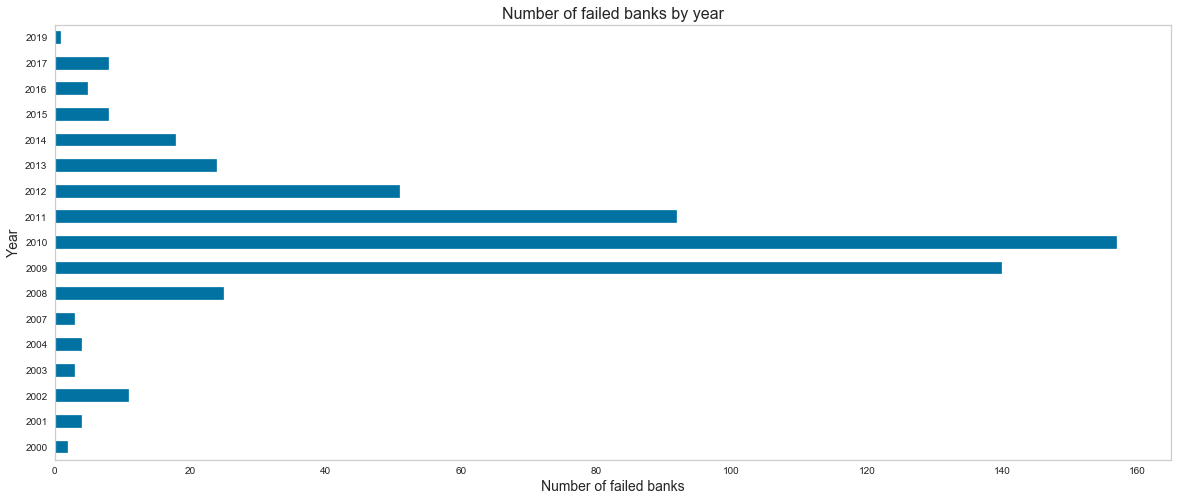

In [4]:
ax = failed_banks.groupby(failed_banks.Date.dt.year)['Bank Name'].count().plot(
    kind='barh', color='b', figsize=(20, 8))
ax.grid()
ax.set_xlabel("Number of failed banks", fontsize=14)
ax.set_ylabel("Year", fontsize=14)
plt.title(label ="Number of failed banks by year", fontsize=16)
plt.show()

### Zoom into financials of the banks that failed in 2011-Q3

In [5]:
failed_universe = pd.read_csv('data/failed_universe.csv', index_col=0)

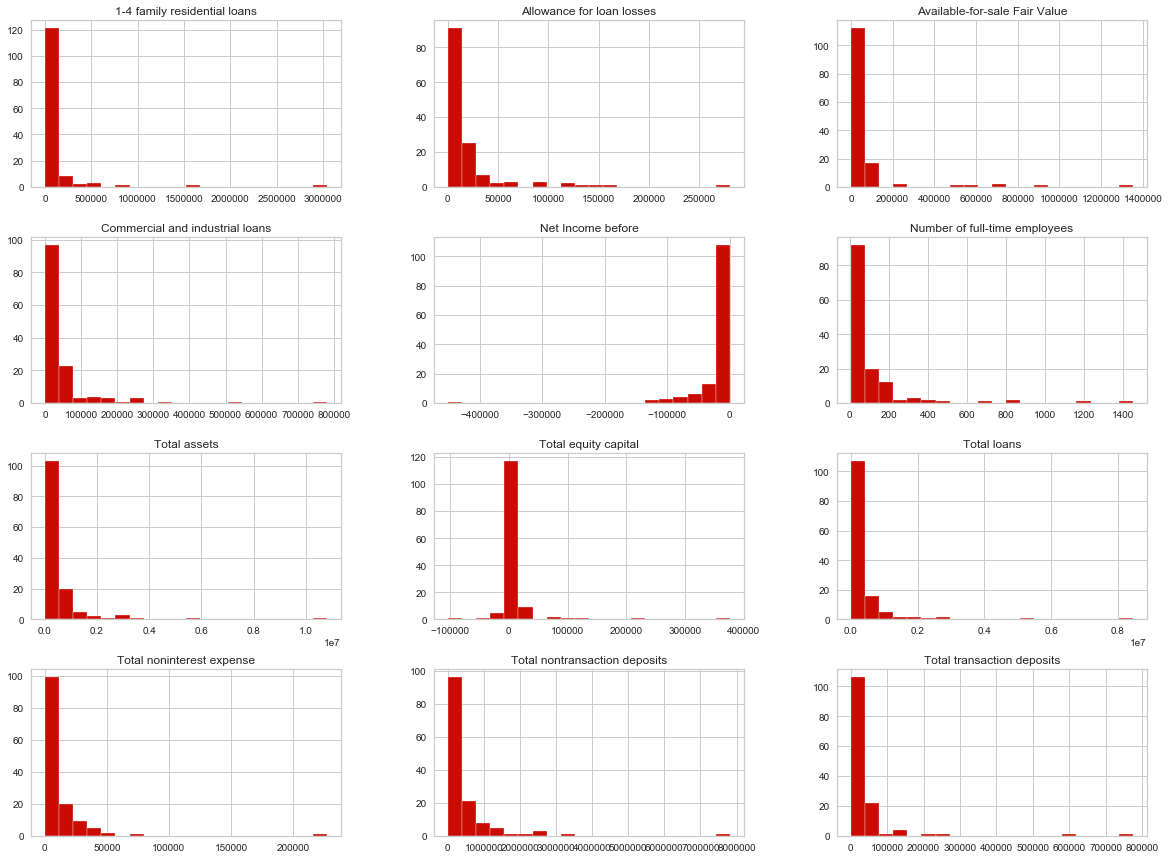

In [6]:
failed_universe_eda = failed_universe.drop(['AsOfDate', 'Target'], axis=1) #Drop control var for EDA purposes
failed_universe_eda.drop(['Other real estate loans', 'Credit cards'], axis=1).hist(figsize=(20,15), alpha=1, bins=20, color='r')
plt.xticks(rotation=0)
plt.show()

In [21]:
corr = failed_universe_eda.drop(['Other real estate loans', 'Credit cards'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Total equity capital,Total assets,Total loans,1-4 family residential loans,Commercial and industrial loans,Allowance for loan losses,Total noninterest expense,Net Income before,Total transaction deposits,Total nontransaction deposits,Available-for-sale Fair Value,Number of full-time employees
Total equity capital,1,0.846364,0.870626,0.714006,0.47477,0.601654,0.2197,-0.159871,0.860785,0.805219,0.673638,0.757573
Total assets,0.846364,1,0.989727,0.792217,0.69808,0.886844,0.4321,-0.400298,0.862182,0.993455,0.848218,0.947683
Total loans,0.870626,0.989727,1,0.828552,0.668857,0.863746,0.399238,-0.380347,0.90412,0.975916,0.780347,0.943038
1-4 family residential loans,0.714006,0.792217,0.828552,1,0.41762,0.603794,0.239605,-0.283683,0.928536,0.740525,0.566289,0.83676
Commercial and industrial loans,0.47477,0.69808,0.668857,0.41762,1,0.848777,0.866905,-0.820063,0.528845,0.7261,0.585293,0.628219
Allowance for loan losses,0.601654,0.886844,0.863746,0.603794,0.848777,1,0.636984,-0.632138,0.680095,0.908372,0.756411,0.827573
Total noninterest expense,0.2197,0.4321,0.399238,0.239605,0.866905,0.636984,1,-0.956005,0.300902,0.468338,0.311816,0.391634
Net Income before,-0.159871,-0.400298,-0.380347,-0.283683,-0.820063,-0.632138,-0.956005,1,-0.318804,-0.428323,-0.231149,-0.351115
Total transaction deposits,0.860785,0.862182,0.90412,0.928536,0.528845,0.680095,0.300902,-0.318804,1,0.812566,0.602041,0.856582
Total nontransaction deposits,0.805219,0.993455,0.975916,0.740525,0.7261,0.908372,0.468338,-0.428323,0.812566,1,0.848807,0.942249


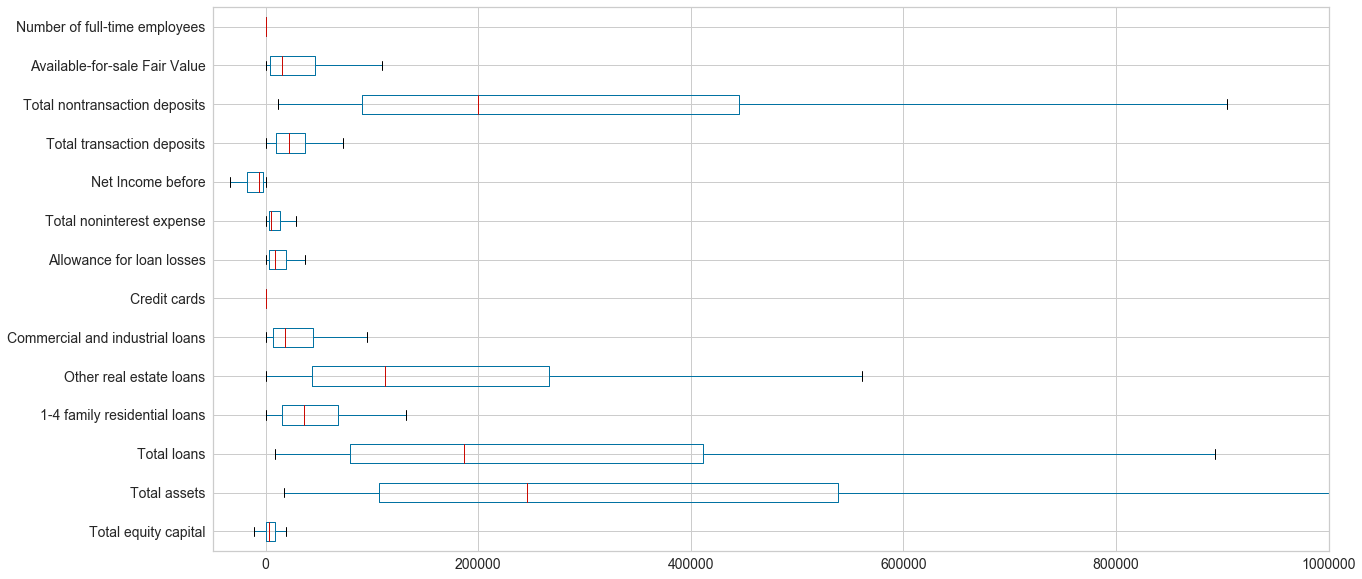

In [7]:
failed_universe_eda.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.show()

### Compare to financials of the banks that were healthy after 2011-Q3

In [9]:
# Import healthy banks, set AsOfDate as 9/30/2010 for 2010Q3, code target as "0", i.e. healthy bank, safe to file
healthy_universe = pd.read_csv('data/healthy_after_2010Q3', index_col=0)

In [10]:
corr = healthy_universe.drop(['Other real estate loans', 'Credit cards'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Total equity capital,Total assets,Total loans,1-4 family residential loans,Commercial and industrial loans,Allowance for loan losses,Total noninterest expense,Net Income before,Total transaction deposits,Total nontransaction deposits,Available-for-sale Fair Value,Number of full-time employees
Total equity capital,1,0.975533,0.952543,0.333119,0.788326,0.835243,0.888891,0.442292,0.341356,0.851388,0.436179,0.796384
Total assets,0.975533,1,0.952385,0.443389,0.813072,0.761649,0.863592,0.475369,0.43253,0.918846,0.536451,0.791871
Total loans,0.952543,0.952385,1,0.482164,0.716293,0.855862,0.915914,0.42245,0.355313,0.788163,0.286439,0.815393
1-4 family residential loans,0.333119,0.443389,0.482164,1,0.282998,0.0843113,0.296173,0.507067,0.221423,0.434516,0.170817,0.162703
Commercial and industrial loans,0.788326,0.813072,0.716293,0.282998,1,0.488497,0.612598,0.434233,0.409569,0.823856,0.606442,0.574245
Allowance for loan losses,0.835243,0.761649,0.855862,0.0843113,0.488497,1,0.892245,0.127923,0.126227,0.511893,0.0381175,0.797113
Total noninterest expense,0.888891,0.863592,0.915914,0.296173,0.612598,0.892245,1,0.265852,0.368838,0.689241,0.246257,0.896811
Net Income before,0.442292,0.475369,0.42245,0.507067,0.434233,0.127923,0.265852,1,0.190094,0.463787,0.347266,0.189596
Total transaction deposits,0.341356,0.43253,0.355313,0.221423,0.409569,0.126227,0.368838,0.190094,1,0.499938,0.481709,0.562661
Total nontransaction deposits,0.851388,0.918846,0.788163,0.434516,0.823856,0.511893,0.689241,0.463787,0.499938,1,0.737704,0.655711


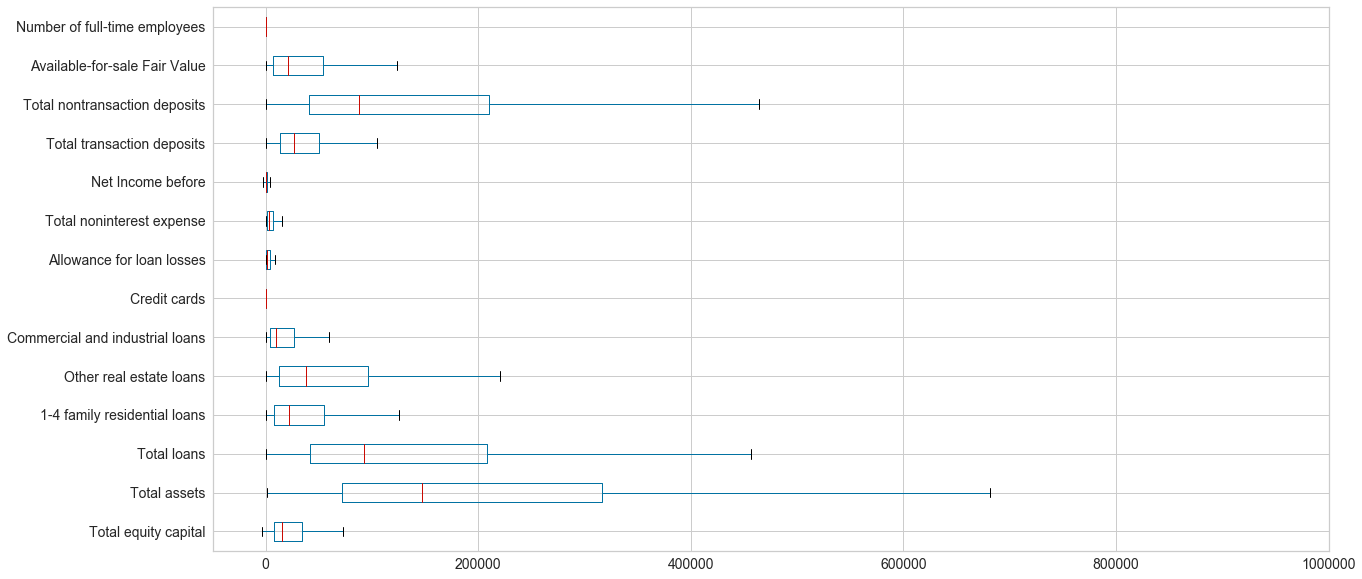

In [11]:
healthy_universe.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.show()

In [26]:
healthy_universe.shape

(7094, 14)

In [27]:
failed_universe_eda.shape

(139, 14)

In [28]:
all_bank_financials = pd.concat([healthy_universe, failed_universe_eda])
all_bank_financials.set = all_bank_financials.dropna()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [29]:
X = all_bank_financials
# Standardizing the features for PCS
X_pca_std = StandardScaler().fit_transform(X)

In [30]:
place_holder_df = pd.DataFrame(X_pca_std)
place_holder_df.fillna(value=0, inplace=True)
X_pca_std = np.array(place_holder_df)

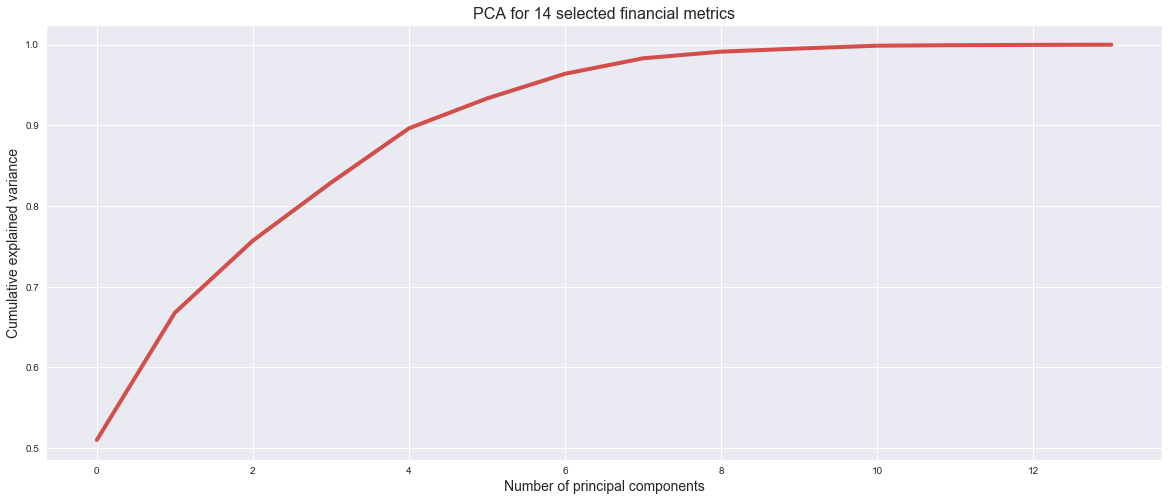

In [31]:
# Run PCA and plot variance explained by CAMELS dimensions (feautures)
pca = PCA().fit(X_pca_std)
plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), alpha=0.7, linewidth=4, color='r')
plt.xlabel('Number of principal components', fontsize=14)
plt.ylabel('Cumulative explained variance', fontsize=14)
plt.title('PCA for 14 selected financial metrics', fontsize=16)
plt.show()

# Creating Early Warning model based CAMELS data set from 2010-Q3

In [32]:
camel_insample = pd.read_csv('data/camel_data_after2010Q3.csv', index_col = 0)

In [33]:
camel_model_set = camel_insample.dropna()

## Over-sampling with SMOTE

In [51]:
y = camel_model_set['Target']
X = camel_model_set.drop(['Target', 'AsOfDate'], axis=1)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [53]:
print('Original dataset shape %s' % Counter(y_train))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_train_std_res, y_train_res = sm.fit_resample(X_train_std, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({0: 5501, 1: 110})
Resampled dataset shape Counter({0: 5501, 1: 5501})


## Investigating importance of CAMELS features with Decision Trees

In [54]:
# TODO: introduction to CAMELS risk dimensions    
framework_CAMELS = {'EQTA':"Bank equity to assets", 
                   'EQTL': "Bank equity to loans",
                   'LLRTA': "Loan loss reserves to assets",
                   'LLRGL' : 'Loan loss reserves to loans',
                   'OEXTA': "Operating expenses to assets",
                   'INCEMP': "Net Income to number of employees",
                   'ROA': 'Return on assets',
                   'ROE': 'Return on equity',
                   'TDTL':'Loans to customer deposits',
                   'TDTA': 'Customer deposits to assets',
                   'TATA': "Tradeble securities to assets"}

## Traing various models and evaluating classification accuracy

In [56]:
models = {
    'logistic_reg' : LogisticRegression(C=1, solver='lbfgs'),
    'stochastic_gd' : SGDClassifier(),
    'gauss_nb' : GaussianNB(),
    'svm' : SVC(C=1, gamma='auto'),
    'decision_tree' : DecisionTreeClassifier(),
    'extra_tree' : ExtraTreeClassifier(),
    'random_forest' : RandomForestClassifier(n_estimators=100),
    'ada_boost' : AdaBoostClassifier(),
    'xgb_classifier' : XGBClassifier(),
    'dnn_classifier' : MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-5 ,hidden_layer_sizes=2*[75])
}

accuracy = {}
precision_scores_is = {}
recall_scores_is = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_test_std)
    recall_scores_is[model] = recall_score(y_test, y_predicted).round(2)
    precision_scores_is[model] = precision_score(y_test, y_predicted).round(2)

In [57]:
recall_scores_is

{'logistic_reg': 0.93,
 'stochastic_gd': 0.96,
 'gauss_nb': 1.0,
 'svm': 0.85,
 'decision_tree': 0.63,
 'extra_tree': 0.59,
 'random_forest': 0.74,
 'ada_boost': 0.89,
 'xgb_classifier': 0.89,
 'dnn_classifier': 0.81}

In [58]:
precision_scores_is

{'logistic_reg': 0.4,
 'stochastic_gd': 0.39,
 'gauss_nb': 0.04,
 'svm': 0.45,
 'decision_tree': 0.49,
 'extra_tree': 0.43,
 'random_forest': 0.62,
 'ada_boost': 0.38,
 'xgb_classifier': 0.51,
 'dnn_classifier': 0.59}

### In-sample recall score is of most importance in predicting failed banks

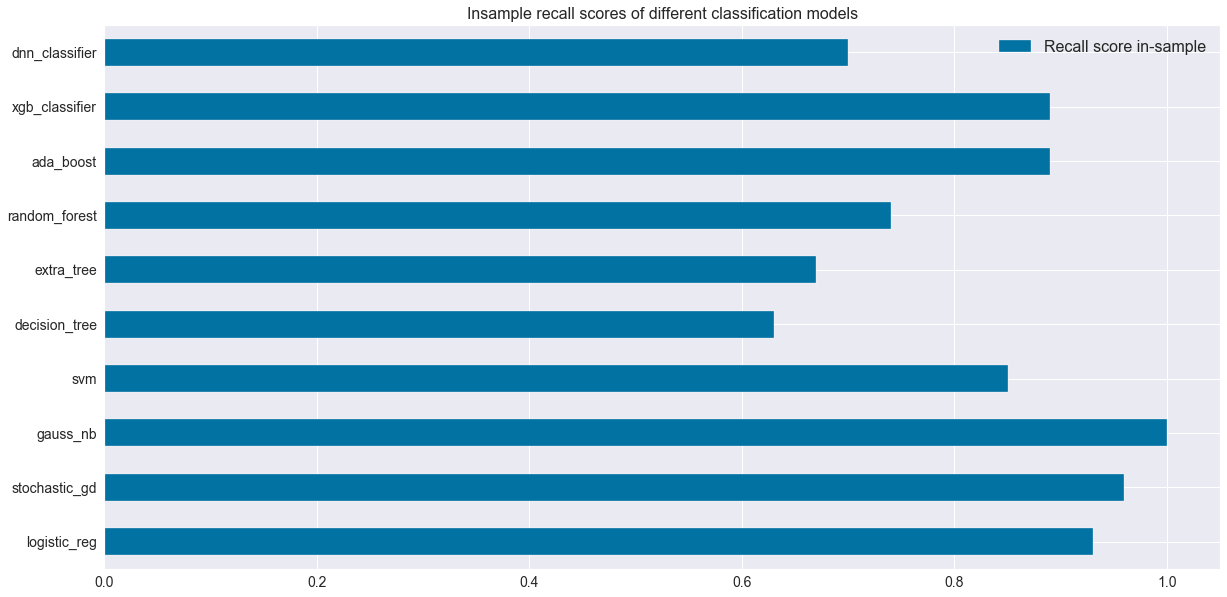

In [42]:
df = pd.DataFrame.from_dict(recall_scores_is, orient='index', columns=['Recall score in-sample'])
df.plot(kind='barh', figsize=(20, 10), fontsize=14)
plt.legend(fontsize=16)
plt.title("Insample recall scores of different classification models", fontsize=16)
plt.show()

## Validation on out-of-sample data 2010Q4 - 2012Q2

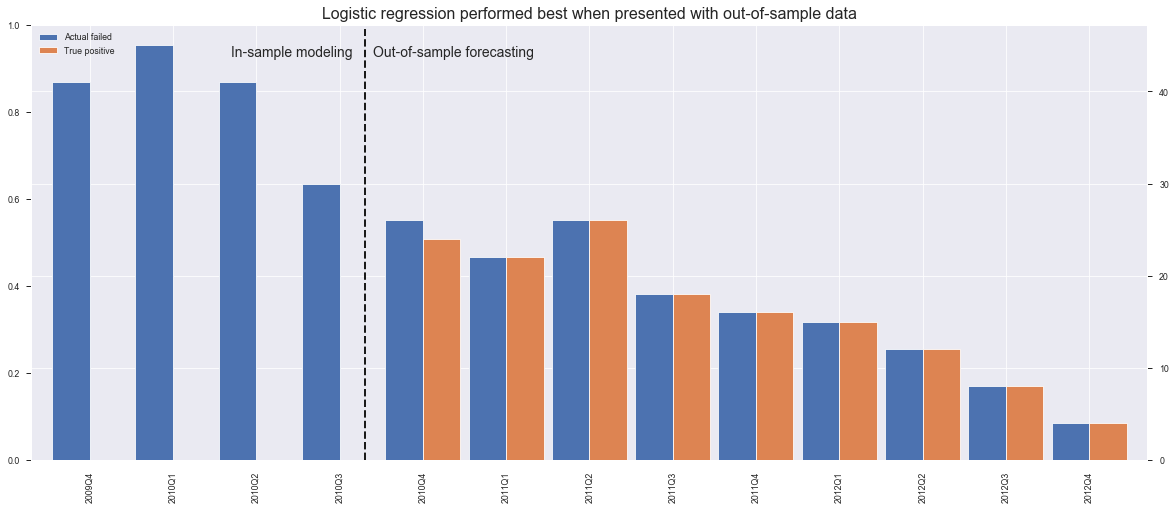

In [47]:
sns.set(font_scale=1)
sns.set_context("paper")
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()
final_results_df[['Actual failed', 'True positive']].plot(ax=ax1, kind='bar', width=0.9).legend(loc='upper left')
#final_results_df['Assets lost'].plot(ax=ax2, kind='line', linewidth=5, style='r', marker='d').legend(loc='upper right')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
plt.axvline(x=3.3, ymin=0, ymax = 0.99, linewidth=2, color='k', linestyle='--')
ax1.text(x= 1.7, y=45, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.4, y=45, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
ax2.grid(False)
plt.title('Logistic regression performed best when presented with out-of-sample data', fontsize=16)
plt.show()


In [33]:
# checking the models out of sample for 2010 Q4
recalls_oos_df = pd.DataFrame()

In [168]:
camel_outofsample = pd.read_csv('data/camel_data_after2010Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [35]:
y_oos_2010Q4 = camel_validation_set['Target']
X_oos_2010Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2010Q4)
X_oos_std_2010Q4 = scaler.transform(X_oos_2010Q4)

In [36]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2010Q4)
    recall_scores_oos[model] = recall_score(y_oos_2010Q4, y_predicted).round(2)
recalls_oos_df = pd.DataFrame.from_dict(recall_scores_oos, orient='index', columns=['2010Q4'])

In [37]:
# checking the models out of sample for 2011 Q1

In [170]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q1_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [39]:
y_oos_2011Q1 = camel_validation_set['Target']
X_oos_2011Q1 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q1)
X_oos_std_2011Q1 = scaler.transform(X_oos_2011Q1)

In [40]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q1)
    recall_scores_oos[model] = recall_score(y_oos_2011Q1, y_predicted).round(2)
recalls_oos_df['2011Q1'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [41]:
# checking the models out of sample for 2011 Q2

In [42]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q2_OOS.csv', index_col = 0)
camel_outofsample.replace([np.inf, -np.inf], 'NaN', inplace=True)
camel_validation_set = camel_outofsample.dropna()

In [44]:
y_oos_2011Q2 = camel_validation_set['Target']
X_oos_2011Q2 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)

In [45]:
X_oos_2011Q2.replace([np.inf, -np.inf], 'NaN', inplace=True)
X_oos_2011Q2 = X_oos_2011Q2.dropna()
len(X_oos_2011Q2)

6689

In [46]:
scaler = StandardScaler()
scaler.fit(X_oos_2011Q2)
X_oos_std_2011Q2 = scaler.transform(X_oos_2011Q2)

In [47]:
place_holder_df = pd.DataFrame(X_oos_std_2011Q2)
place_holder_df.fillna(value=0, inplace=True)
X_oos_std_2011Q2 = np.array(place_holder_df)

In [48]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q2)
    recall_scores_oos[model] = recall_score(y_oos_2011Q2, y_predicted).round(2)
recalls_oos_df['2011Q2'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [49]:
#Validation on 2011 Q3 data

In [172]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q3_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()


In [51]:
y_oos_2011Q3 = camel_validation_set['Target']
X_oos_2011Q3 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q3)
X_oos_std_2011Q3 = scaler.transform(X_oos_2011Q3)

In [52]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q3)
    recall_scores_oos[model] = recall_score(y_oos_2011Q3, y_predicted).round(2)
recalls_oos_df['2011Q3'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [53]:
# Validation on 2011 Q4

In [174]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [55]:
y_oos_2011Q4 = camel_validation_set['Target']
X_oos_2011Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2011Q4)
X_oos_std_2011Q4 = scaler.transform(X_oos_2011Q4)

In [56]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2011Q4)
    recall_scores_oos[model] = recall_score(y_oos_2011Q4, y_predicted).round(2)
recalls_oos_df['2011Q4'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [57]:
# Validation on 2012 Q1

In [176]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q1_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()


In [59]:
y_oos_2012Q1 = camel_validation_set['Target']
X_oos_2012Q1 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q1)
X_oos_std_2012Q1 = scaler.transform(X_oos_2012Q1)

In [60]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q1)
    recall_scores_oos[model] = recall_score(y_oos_2012Q1, y_predicted).round(2)
recalls_oos_df['2012Q1'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [61]:
# Validation on 2012 Q2

In [178]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q2_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [63]:
y_oos_2012Q2 = camel_validation_set['Target']
X_oos_2012Q2 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q2)
X_oos_std_2012Q2 = scaler.transform(X_oos_2012Q2)

In [64]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q2)
    recall_scores_oos[model] = recall_score(y_oos_2012Q2, y_predicted).round(2)
recalls_oos_df['2012Q2'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [65]:
# Validation on 2012 Q3

In [180]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q3_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [67]:
y_oos_2012Q3 = camel_validation_set['Target']
X_oos_2012Q3 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q3)
X_oos_std_2012Q3 = scaler.transform(X_oos_2012Q3)

In [68]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q3)
    recall_scores_oos[model] = recall_score(y_oos_2012Q3, y_predicted).round(2)
recalls_oos_df['2012Q3'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

In [69]:
# Validation on 2012 Q4

In [182]:
camel_outofsample = pd.read_csv('data/camel_data_after2012Q4_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()

In [71]:
y_oos_2012Q4 = camel_validation_set['Target']
X_oos_2012Q4 = camel_validation_set.drop(columns=['Target', 'AsOfDate'], axis=1)
scaler = StandardScaler()
scaler.fit(X_oos_2012Q4)
X_oos_std_2012Q4 = scaler.transform(X_oos_2012Q4)

In [72]:
recall_scores_oos = {}
for model in models:
    y_predicted = models[model].fit(X_train_std_res, y_train_res).predict(X_oos_std_2012Q4)
    recall_scores_oos[model] = recall_score(y_oos_2012Q4, y_predicted).round(2)
recalls_oos_df['2012Q4'] = pd.DataFrame.from_dict(recall_scores_oos, orient='index')

## Out-of-sample validation summary results

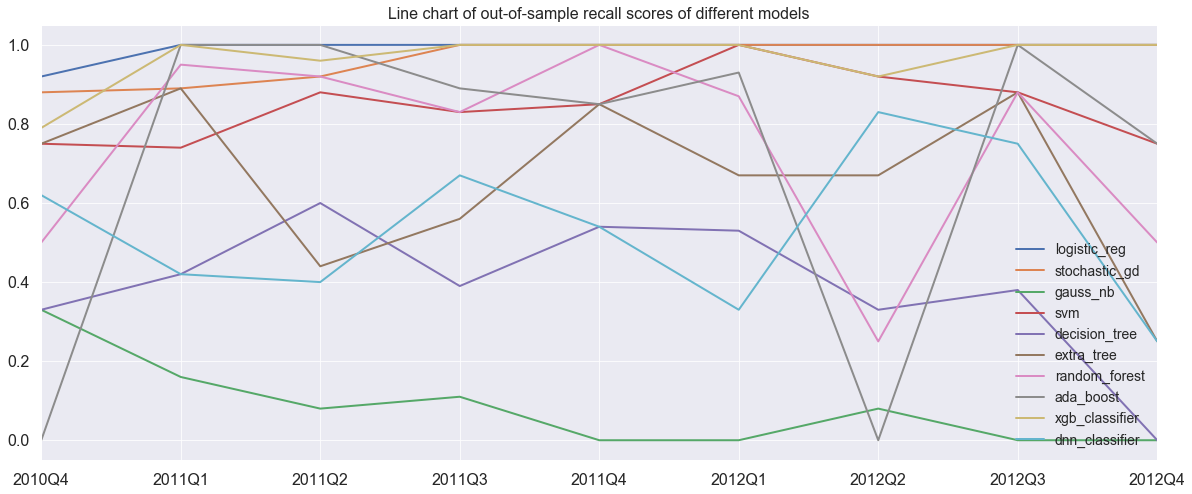

In [91]:
recalls_oos_df.T.plot(kind='line', figsize=(20,8), linewidth=2, fontsize=16).legend(loc='lower right', fontsize=14)
plt.title("Line chart of out-of-sample recall scores of different models", fontsize=16)
plt.show()

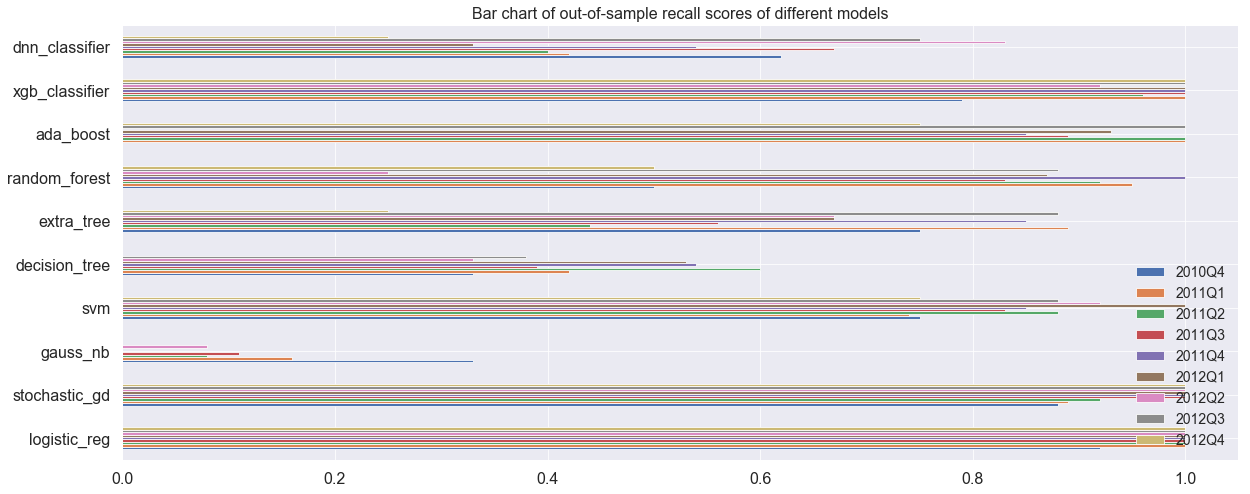

In [85]:
recalls_oos_df.plot(kind='barh', figsize=(20,8), fontsize=16).legend(loc='lower right', fontsize=14)
plt.title("Bar chart of out-of-sample recall scores of different models", fontsize=16)
plt.show()

In [140]:
# To get the value of precision we divide the total number of correctly classified positive examples 
# by the total number of predicted positive examples. 
# High Precision indicates an example labeled as positive is indeed positive (small number of FP).

# Recall can be defined as the ratio of the total number of correctly classified positive 
# examples divide to the total number of positive examples. 
# High Recall indicates the class is correctly recognized (small number of FN).

# High recall, low precision:This means that most of the positive examples are correctly recognized (low FN) 
# but there are a lot of false positives. Low recall, high precision:This shows that we miss a lot 
# of positive examples (high FN) but those we predict as positive are indeed positive (low FP)


In [195]:
4/6939


0.0005764519383196426

In [45]:
banks_data = {'2009Q4': {'Actual failed': 41, 'True positive': 0, 'False positive': 0},
              '2010Q1': {'Actual failed': 45, 'True positive': 0, 'False positive': 0},
              '2010Q2': {'Actual failed': 41, 'True positive': 0, 'False positive': 0},
              '2010Q3': {'Actual failed': 30, 'True positive': 0, 'False positive': 0},
              '2010Q4': {'Actual failed': 26, 'True positive': 24, 'False positive': 0},
              '2011Q1': {'Actual failed': 22, 'True positive': 22, 'False positive': 0},
              '2011Q2': {'Actual failed': 26, 'True positive': 26, 'False positive': 0},
              '2011Q3': {'Actual failed': 18, 'True positive': 18, 'False positive': 0},
              '2011Q4': {'Actual failed': 16, 'True positive': 16, 'False positive': 0},
              '2012Q1': {'Actual failed': 15, 'True positive': 15, 'False positive': 0},
              '2012Q2': {'Actual failed': 12, 'True positive': 12, 'False positive': 0},
              '2012Q3': {'Actual failed': 8, 'True positive': 8, 'False positive': 0},
              '2012Q4': {'Actual failed': 4, 'True positive': 4, 'False positive': 0}
             }
final_results_df = pd.DataFrame.from_dict(banks_data, orient='index')
final_results_df['Proportion of failed banks'] = [0.0055, 0.0073, 0.0064, 0.0055, 
                                               0.0047, 0.0035, 0.0041, 0.0039,
                                               0.0037, 0.0036, 0.0013, 0.0012, 
                                               0.00011]

final_results_df

,Actual failed,True positive,False positive,Proportion of failed banks
2009Q4,41,0,0,0.00550
2010Q1,45,0,0,0.00730
2010Q2,41,0,0,0.00640
2010Q3,30,0,0,0.00550
2010Q4,26,24,0,0.00470
2011Q1,22,22,0,0.00350
2011Q2,26,26,0,0.00410
2011Q3,18,18,0,0.00390
2011Q4,16,16,0,0.00370
2012Q1,15,15,0,0.00360


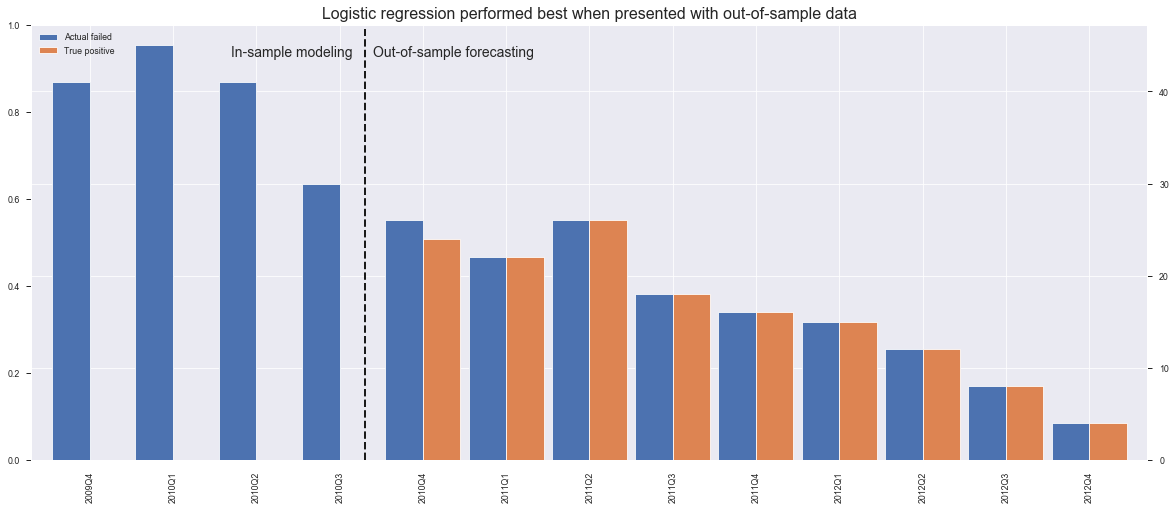

In [46]:
sns.set(font_scale=1)
sns.set_context("paper")
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()
final_results_df[['Actual failed', 'True positive']].plot(ax=ax1, kind='bar', width=0.9).legend(loc='upper left')
#final_results_df['Proportion of failed bank'].plot(ax=ax2, kind='line', linewidth=5, style='r', marker='d') #.legend(loc='upper right')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
plt.axvline(x=3.3, ymin=0, ymax = 0.99, linewidth=2, color='k', linestyle='--')
ax1.text(x= 1.7, y=45, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.4, y=45, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
ax2.grid(False)
plt.title('Logistic regression performed best when presented with out-of-sample data', fontsize=16)
plt.show()
